# Auswertung des (zeitlichen) Nutzungsverhalten

In [2]:
import datetime as dt
import os

import src.project_definitions as eb

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages

from src import style, graphs
style.set_rc_eb_standard()

### Import update_databases um die Datenbank täglich automatisch zu aktualisieren....
#from src import update_databases

import src.project_definitions as eb
import src.utilities as ut
import src.sensor_reader as sr

import locale
locale.setlocale(locale.LC_ALL,'de_DE')

### ACHTUNG: Diese Zeilen nur aktivieren wenn Sicher ist, dass der Code funktioniert.
import warnings
warnings.filterwarnings('ignore')

#### Messdaten Import
IND = {bui: sr.load_tf_bui(bui,'1min') for bui in eb.buid}
#IND = pd.concat(IND,axis=1)

##### USER INPUTS #####
ex = False

## Vergleich der Tagesverläufe der Sensoren
___

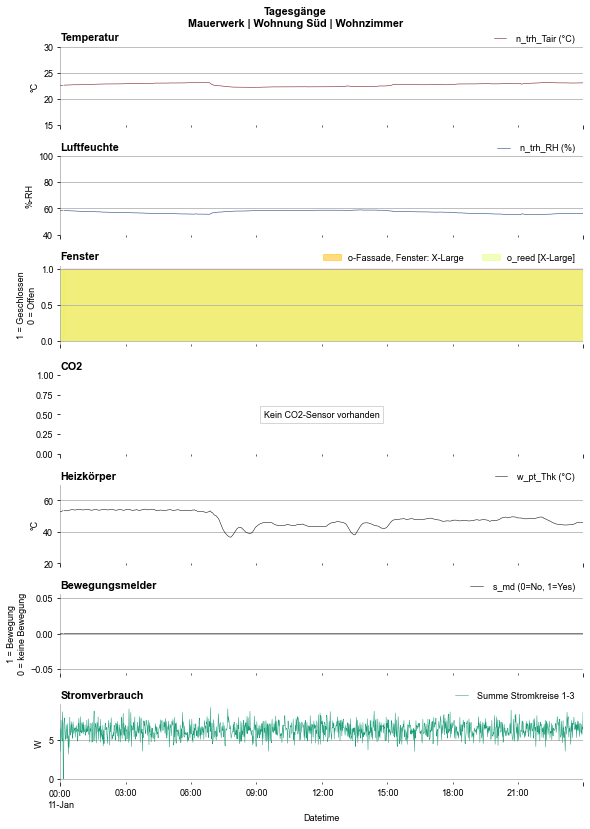

In [3]:
bui = 'MW'

app = 'S'       # 'N' = Nord, 'S' = Süd, 'O' = Ost

room = 'WZ'     # 'WZ', 'SZ', 'F', 'K': Nord, Süd; 'B': Alle; 'SWK': nur Ost

date = '2022-1-11'

fig, axs = plt.subplots(7,1, figsize=style.din_a4, sharex=True)

mpl.style.use('./src/stylesheets/DailyApp.mplstyle')
fig.suptitle(f'Tagesgänge\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}', fontweight = 'bold')

ax = axs[0]
ax.set_title('Temperatur')
IND[bui][app][room].loc[date].filter(like='_trh_Tair').plot(ax=ax,cmap='Reds_r')
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_ylim(15, 30)
ax.set_ylabel('°C')

ax = axs[1]
ax.set_title('Luftfeuchte')
IND[bui][app][room].loc[date].filter(like='_trh_RH').plot(ax=ax,cmap='Blues_r',label = ['Raumluftfeuchte'])
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_ylim(40, 100)
ax.set_ylabel('%-RH')

ax = axs[2]
ax.set_title('Fenster')
try:
    windows = IND[bui][app][room].loc[date].filter(like='reed ').replace(['Closed', 'Open'], [1,0])
    windows.plot(ax=ax, cmap='Purples_r',label=[f'{col.split("_")[0]}-Fassade, Fenster: {col.split("[")[1].replace("]","")}' for col in windows.columns])
    for w,col in enumerate(windows.columns):
        norm = mpl.colors.Normalize(vmin=0, vmax=len(windows.columns))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Wistia_r)
        cmap.set_array([])
        label = f'{col.split("_")[0]}-Fassade, Fenster: {col.split("[")[1].replace("]","")}'
        
        ax.fill_between(x=windows[col].index, y1=windows[col], label=label, color=cmap.to_rgba(w + 1), alpha=0.5)
    han, lab = ax.get_legend_handles_labels()
    ax.legend(labels = list(set(lab)) , handles=[x for x in han if isinstance(x, mpl.collections.PolyCollection)], loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

    ax.set_ylabel('1 = Geschlossen\n0 = Offen')
except Exception as e:
    ax.text(0.5,0.5,'Kein Fenster vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=style.eb_bbox, 
                )
    print(e)

ax = axs[3]
ax.set_title('CO2')
try:
    IND[bui][app][room].loc[date].filter(like='_co2 ').plot(ax=ax,cmap='Greens_r')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    ax.set_ylim(0,3000)
    ax.set_ylabel('ppm')
except:
    ax.text(0.5,0.5,'Kein CO2-Sensor vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=style.eb_bbox, 
                )
    pass

ax = axs[4]
ax.set_title('Heizkörper')
try:
    IND[bui][app][room].loc[date].filter(like='pt_Thk ').plot(ax=ax,cmap='Greys_r', label = 'Oberflächentemperatur')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    if bui in ['LB', 'MH']:
        ax.set_ylim(20, 50)
    if bui == 'MW':
        ax.set_ylim(20, 70)
    ax.set_ylabel('°C')
except:
    ax.text(0.5,0.5,'Keine Heizkörpertemperatur vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=style.eb_bbox, 
                )
    pass

ax = axs[5]
ax.set_title('Bewegungsmelder')
try:
    IND[bui][app][room].loc[date].filter(like='_md ').plot(ax=ax,cmap='Greys_r')
    ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    ax.set_ylabel('1 = Bewegung\n0 = keine Bewegung')
except:
    ax.text(0.5,0.5,'Kein Bewegungsmelder vorhanden',
                style='normal', 
                ha = 'center', 
                va = 'center',
                transform=ax.transAxes,
                bbox=style.eb_bbox, 
                )
    pass

ax = axs[6]
IND[bui][app][''].loc[date].filter(like='(W)').sum(axis=1).plot(ax=ax,cmap='Dark2', label = 'Summe Stromkreise 1-3') #.sum(axis=1)
ax.legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
ax.set_title('Stromverbrauch')
#ax.set_ylim(0, 2500)
ax.set_ylabel('W')
fig.tight_layout()

Text(0.0, 1.0, 'MW | S')

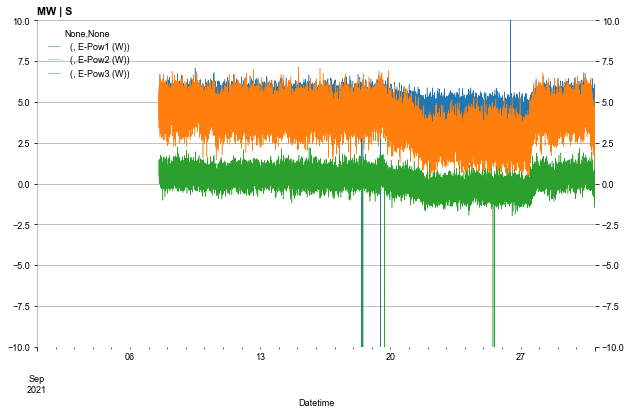

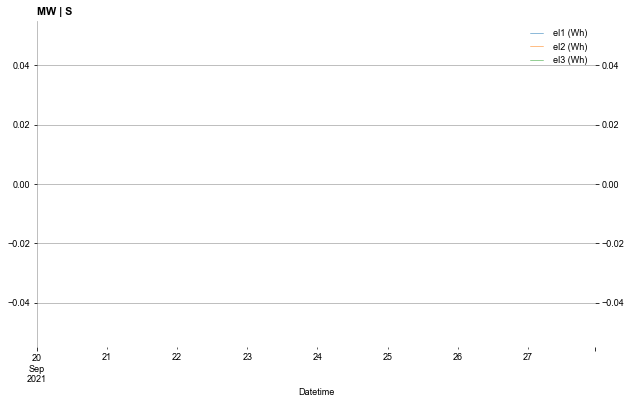

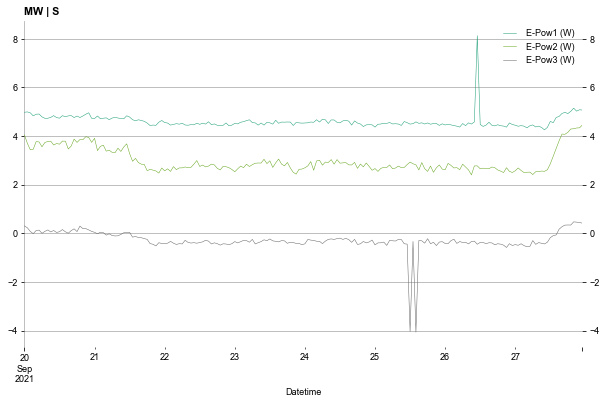

In [18]:
bui = 'MW'
app = 'S'

IND[bui][app].loc['2021-09'].filter(like='(W)').plot()
plt.ylim(-10,10)
plt.title(f'{bui} | {app}')

dfp = IND[bui][app][''].loc['2021-09-20':'2021-09-27'].filter(like='el').diff().resample('H').sum()
dfp = dfp[dfp > 0]
dfp.plot()
plt.title(f'{bui} | {app}')

IND[bui][app][''].loc['2021-09-20':'2021-09-27'].filter(like='(W)').resample('H').mean().plot(cmap='Dark2', label = 'Summe Stromkreise 1-3') #.sum(axis=1)

plt.title(f'{bui} | {app}')

In [5]:
# #fig, axs = plt.subplots(3, 1, figsize=style.din_a4, sharex=False)


# FIG, AXS = {}, {}
# for room in ['K', 'B', 'WZ', 'SZ', 'F']:
#     FIG[room], AXS[room] = plt.subplots(3, 1, figsize=style.din_a4, sharex=False)
    
# for color, bui in zip(['Reds_r', 'Greens_r', 'Blues_r'], eb.buid):
#     df = sr.load_tf_bui(bui,'1min')
#     for app in ['S', 'N']:
#         for room in ['K', 'B', 'WZ', 'SZ', 'F']:
#             #FIG[room], AXS[room] = plt.subplots(3, 1, figsize=style.din_a4, sharex=False)
#             FIG[room].suptitle(f'Tagesprofile\n{eb.buid[bui]} | Wohnung {eb.wohnungen[app]} | {eb.rooms[room]}', fontweight = 'bold')
#             ax = AXS[room][0]
#             dataset = (df[app][room].filter(like='_md').resample('H').sum()).mean(axis=1)
#             #dataset.plot()
#             dfs=[]
#             for i in range(24):
#                 dfs.append(dataset[dataset.index.hour == i])
#             dataset = pd.concat(dfs,axis=1)
#             #dataset.plot.box(ax=ax)
#             MDs[(bui, app, room)] = dataset.mean()
#             dataset.mean().plot(ax=ax,alpha=1, cmap = color)
#             ax.set_title(f'Bewegungsmelder')

#             ax = AXS[room][1]
#             dataset = df[app][room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean().mean(axis=1)
#             dfs=[]
#             for i in range(24):
#                 dfs.append(dataset[dataset.index.hour == i])
#             dataset = pd.concat(dfs,axis=1)
#             #dataset.plot.box(ax=ax)
#             WINs[(bui, app, room)] = dataset.mean()
#             dataset.mean().plot(ax=ax,alpha=1, cmap = color)
#             ax.set_title(f'Fensteröffnung')

#             ax = AXS[room][2]
#             dataset = df[app][''].filter(like='(W)').abs().sum(axis=1).resample('H').mean()
#             dfs=[]
#             for i in range(24):
#                 dfs.append(dataset[dataset.index.hour == i])
#             dataset = pd.concat(dfs,axis=1)
#             #dataset.plot.box(ax=ax)
#             #if bui not in ELs: ELs[bui] = []
#             ELs[(bui, app, '')] = dataset.mean()
#             dataset.mean().plot(ax=ax,alpha=1, cmap = color)
#             ax.set_title(f'Stromverbrauchs')

#             FIG[room].tight_layout()

## Auswertung Fensterkontakt, Bewegungsmelder und Stromverbrauch pro Wohneinheit
___
Mittelwerte über den Tagesverlauf, stündliche Auflösung

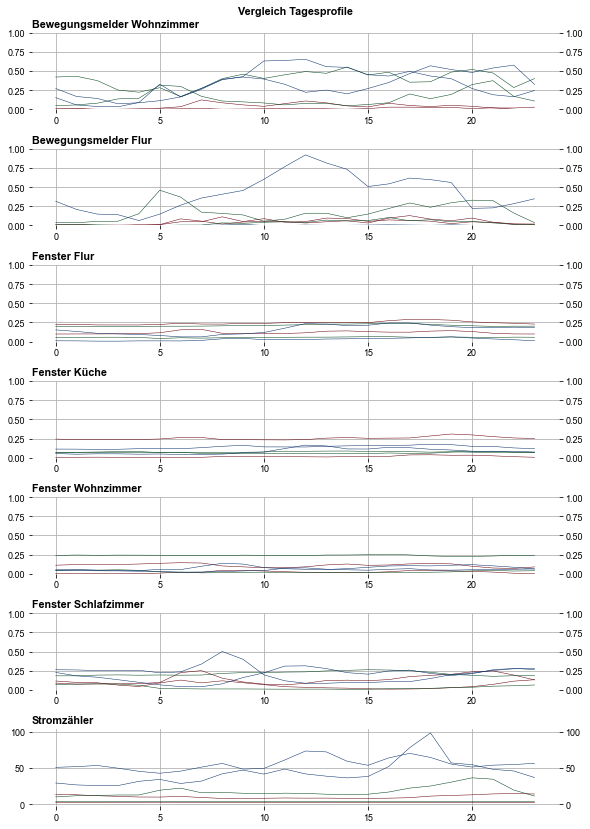

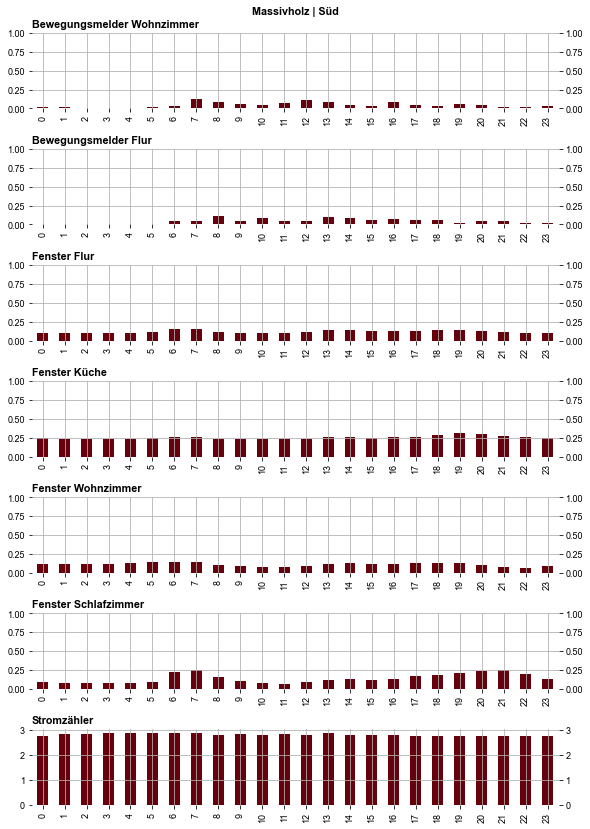

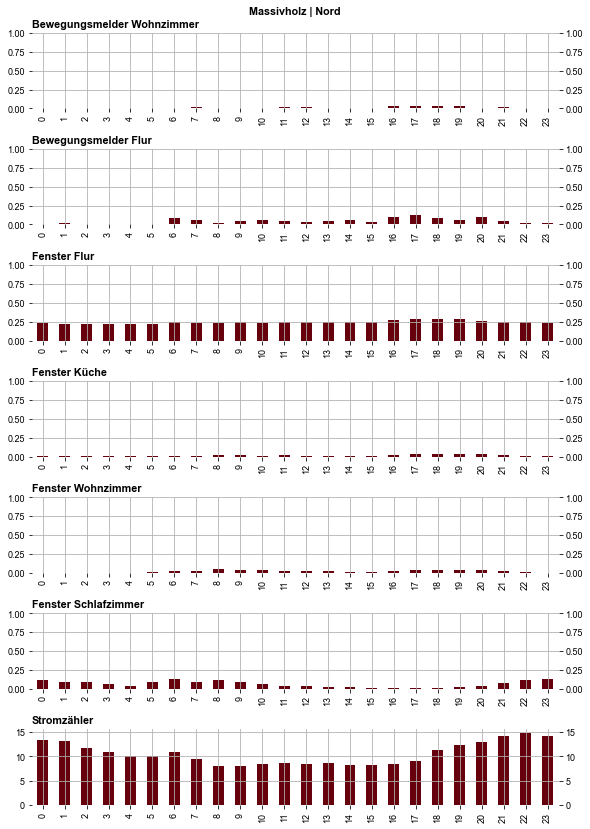

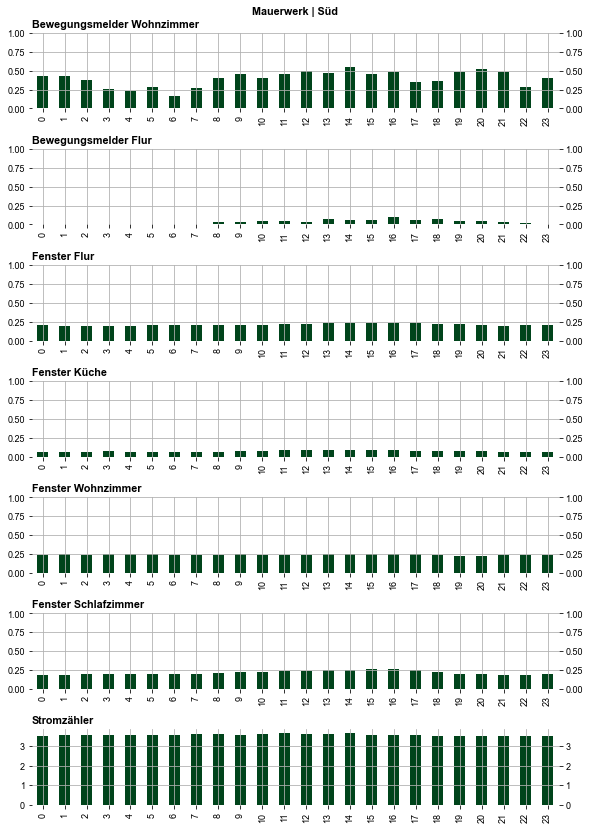

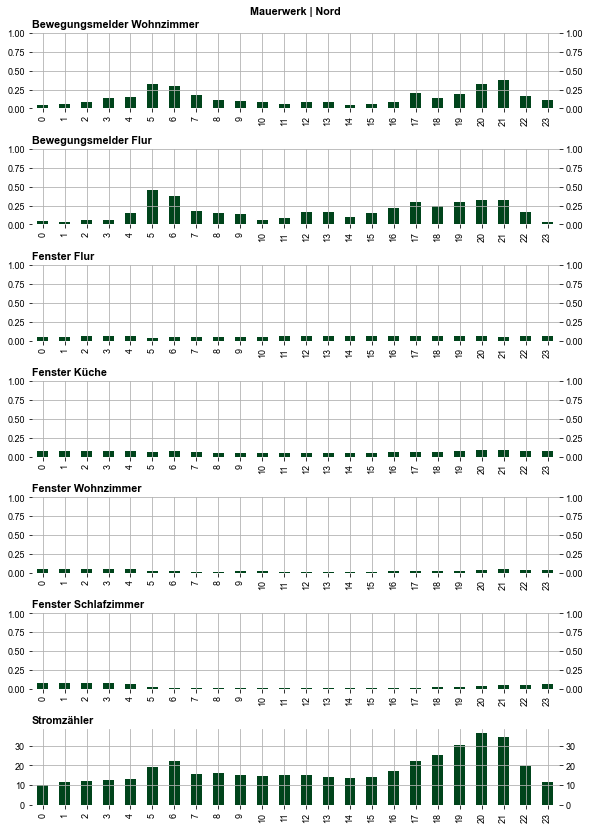

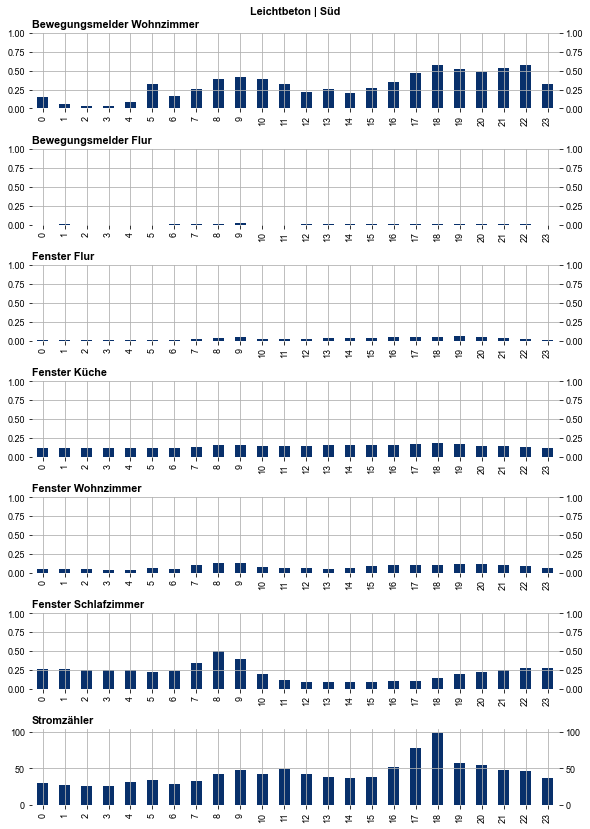

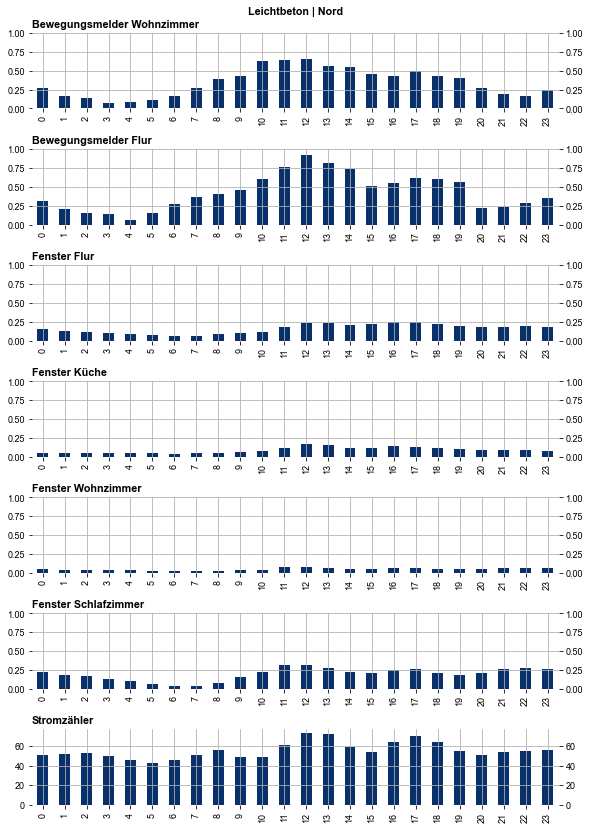

In [6]:
MDs = {}
WINs = {}
ELs = {}

fig, axs = plt.subplots(7,1,figsize=style.din_a4)
fig.suptitle(f'Vergleich Tagesprofile')
for color, bui in zip(['Reds_r', 'Greens_r', 'Blues_r'], eb.buid):
    for app in ['S', 'N']:
        FIG, AX = plt.subplots(7,1,figsize=style.din_a4)
        FIG.suptitle(f'{eb.buid[bui]} | {eb.wohnungen[app]}')

        # Bewegunsmelder Wohnzimmer
        ax = axs[0]
        room = 'WZ'
        dataset = (IND[bui][app][room].filter(like='_md').resample('H').sum()).mean(axis=1)
        dfs=[]
        for i in range(24):
            dfs.append(dataset[dataset.index.hour == i])
        dataset = pd.concat(dfs,axis=1)
        MDs[(bui, app, room)] = dataset.mean()
        dataset.mean().plot(ax=ax,alpha=1, cmap = color)
        
        ax2 = AX[0]
        dataset.mean().plot.bar(ax=ax2,alpha=1, cmap = color)
        for ix in [ax, ax2]:
            ix.set_title(f'Bewegungsmelder Wohnzimmer')
            ix.set_ylim(0,1)
        
        #Fenster Wohnzimmer
        ax = axs[4]
        dataset = IND[bui][app]['WZ'].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean().mean(axis=1)
        dfs=[]
        for i in range(24):
            dfs.append(dataset[dataset.index.hour == i])
        dataset = pd.concat(dfs,axis=1)
        WINs[(bui, app, room)] = dataset.mean()
        dataset.mean().plot(ax=ax,alpha=1, cmap = color)

        ax2 = AX[4]
        dataset.mean().plot.bar(ax=ax2,alpha=1, cmap = color)
        for ix in [ax, ax2]:
            ix.set_title(f'Fenster Wohnzimmer')
            ix.set_ylim(0,1)

        # Bewegunsmelder Flur
        ax = axs[1]
        room = 'F'
        dataset = (IND[bui][app][room].filter(like='_md').resample('H').sum()).mean(axis=1)
        dfs=[]
        for i in range(24):
            dfs.append(dataset[dataset.index.hour == i])
        dataset = pd.concat(dfs,axis=1)
        MDs[(bui, app, room)] = dataset.mean()
        dataset.mean().plot(ax=ax,alpha=1, cmap = color)

        ax2 = AX[1]
        dataset.mean().plot.bar(ax=ax2,alpha=1, cmap = color)
        for ix in [ax, ax2]:
            ix.set_title(f'Bewegungsmelder Flur')
            ix.set_ylim(0,1)

        #Fenster Flur
        ax = axs[2]
        dataset = IND[bui][app][room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean().mean(axis=1)
        dfs=[]
        for i in range(24):
            dfs.append(dataset[dataset.index.hour == i])
        dataset = pd.concat(dfs,axis=1)
        #dataset.plot.box(ax=ax)
        WINs[(bui, app, room)] = dataset.mean()
        dataset.mean().plot(ax=ax,alpha=1, cmap = color)

        ax2 = AX[2]
        dataset.mean().plot.bar(ax=ax2,alpha=1, cmap = color)
        for ix in [ax, ax2]:
            ix.set_title(f'Fenster Flur')
            ix.set_ylim(0,1)

        #Fenster Küche
        ax = axs[3]
        room = 'K'
        dataset = IND[bui][app][room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean().mean(axis=1)
        dfs=[]
        for i in range(24):
            dfs.append(dataset[dataset.index.hour == i])
        dataset = pd.concat(dfs,axis=1)
        WINs[(bui, app, room)] = dataset.mean()
        dataset.mean().plot(ax=ax,alpha=1, cmap = color)

        ax2 = AX[3]
        dataset.mean().plot.bar(ax=ax2,alpha=1, cmap = color)
        for ix in [ax, ax2]:
            ix.set_title(f'Fenster Küche')
            ix.set_ylim(0,1)


        #Fenster Schlafzimmer
        ax = axs[5]
        room = 'SZ'
        dataset = IND[bui][app][room].filter(like='_reed').replace(['Closed', 'Open'],[0,1]).resample('H').mean().mean(axis=1)
        dfs=[]
        for i in range(24):
            dfs.append(dataset[dataset.index.hour == i])
        dataset = pd.concat(dfs,axis=1)
        WINs[(bui, app, room)] = dataset.mean()
        dataset.mean().plot(ax=ax,alpha=1, cmap = color)

        ax2 = AX[5]
        dataset.mean().plot.bar(ax=ax2,alpha=1, cmap = color)
        for ix in [ax, ax2]:
            ix.set_title(f'Fenster Schlafzimmer')
            ix.set_ylim(0,1)

        #Stromzähler
        ax = axs[6]
        room = ''
        dataset = IND[bui][app][room].filter(like='(W)').abs().sum(axis=1).resample('H').mean()
        dfs=[]
        for i in range(24):
            dfs.append(dataset[dataset.index.hour == i])
        dataset = pd.concat(dfs,axis=1)
        ELs[(bui, app, room)] = dataset.mean()
        dataset.mean().plot(ax=ax,alpha=1, cmap = color)

        ax2 = AX[6]
        dataset.mean().plot.bar(ax=ax2,alpha=1, cmap = color)
        for ix in [ax, ax2]:
            ix.set_title(f'Stromzähler')
        FIG.tight_layout()
fig.tight_layout()

## Auswertung Bewegungsmelder, Fensterkontakt und Stromverbrauch pro Raum
___
Stündliche Darstellung

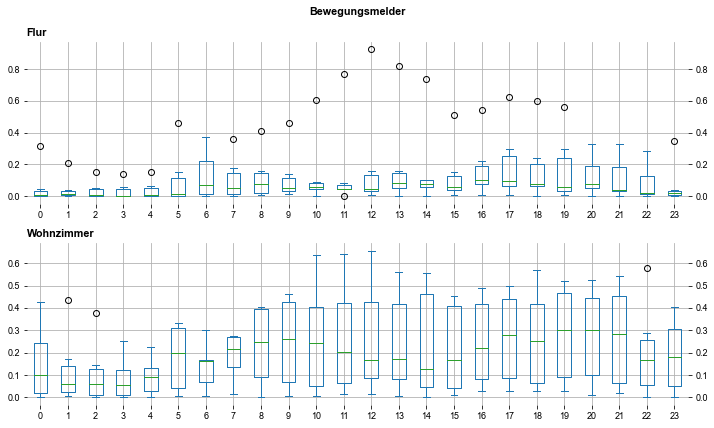

In [7]:
df = pd.DataFrame(MDs).T.dropna(how='all')
df = df.groupby(level=2)
n = len(df.groups)

fig, axs = plt.subplots(n,1)
fig.suptitle(f'Bewegungsmelder')
for i, (name, group) in enumerate(df):
    ax = axs[i]
    group.plot.box(ax=ax)
    ax.set_title(f'{eb.rooms[name]}')
fig.tight_layout()

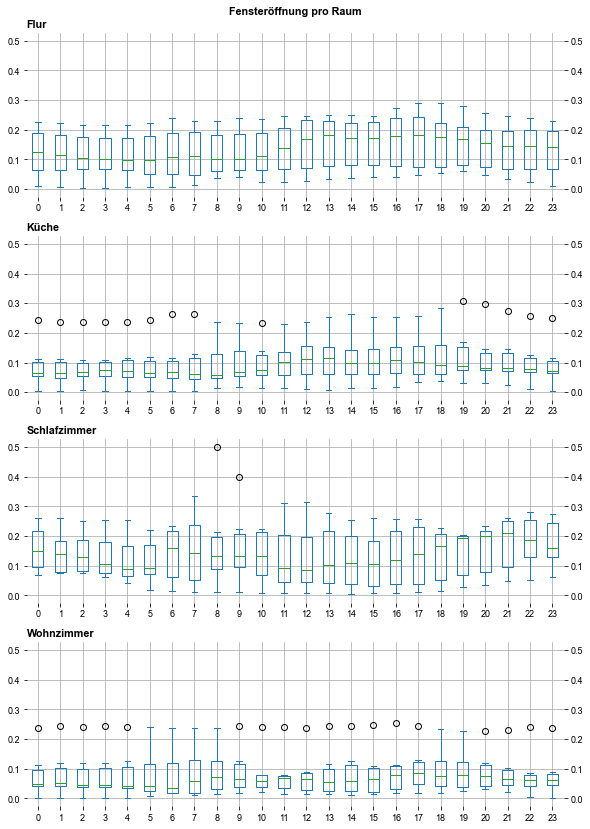

In [8]:
df = pd.DataFrame(WINs).T.dropna(how='all')
df = df.groupby(level=2)
n = len(df.groups)

fig, axs = plt.subplots(n,1, figsize = style.din_a4, sharey=True)
fig.suptitle(f'Fensteröffnung pro Raum')
for i, (name, group) in enumerate(df):
    ax = axs[i]
    group.plot.box(ax=ax)
    ax.set_title(f'{eb.rooms[name]}')
fig.tight_layout()

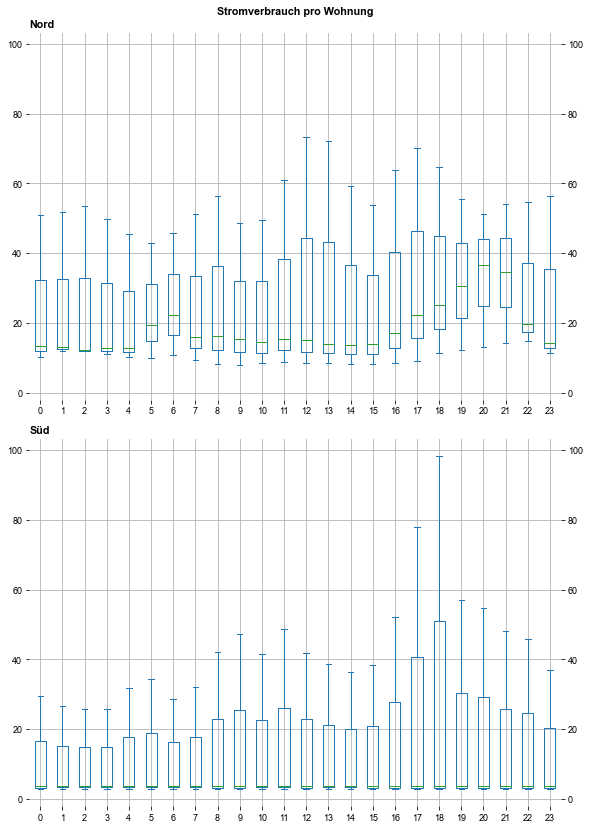

In [9]:
df = pd.DataFrame(ELs).T.dropna(how='all')
df = df.groupby(level=1)
n = len(df.groups)

fig, axs = plt.subplots(n,1, figsize = style.din_a4, sharey=True)
fig.suptitle(f'Stromverbrauch pro Wohnung')
for i, (name, group) in enumerate(df):
    ax = axs[i]
    group.plot.box(ax=ax)
    ax.set_title(f'{eb.wohnungen[name]}')
fig.tight_layout()

## Auswertung Bewegunsmelder, Fensteröffnung, Stromverbrauch
____
gemittelt über alle Räume, Wohnungen und Häuser - stündliche Darstellung

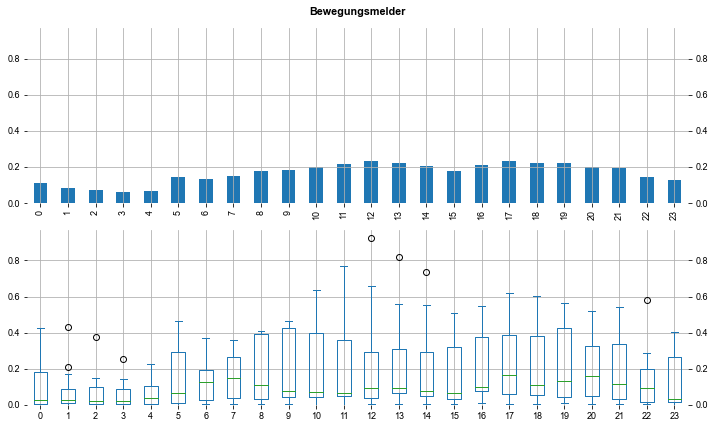

In [10]:
df = pd.DataFrame(MDs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Bewegungsmelder')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

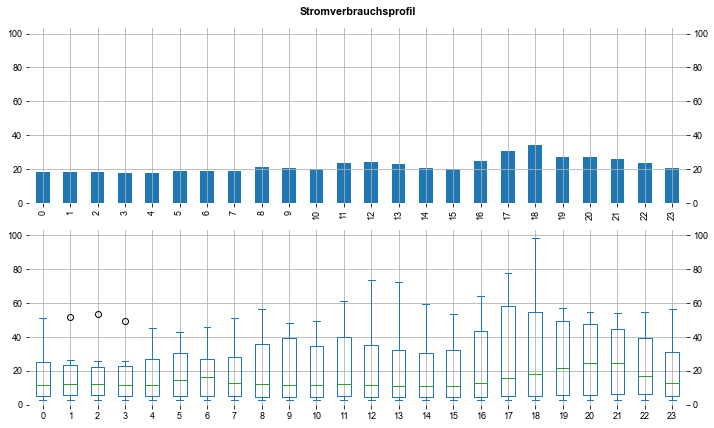

In [11]:
df = pd.DataFrame(ELs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Stromverbrauchsprofil')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

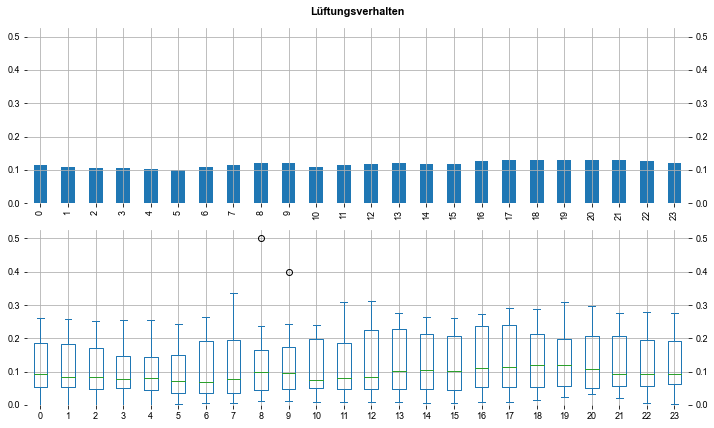

In [12]:
df = pd.DataFrame(WINs)
df = df.dropna(axis=1, how='all')

fig, axs = plt.subplots(2,1, sharey=True)
fig.suptitle('Lüftungsverhalten')
df.T.mean().plot.bar(ax=axs[0],)
df.T.plot.box(ax=axs[1],)
fig.tight_layout()

## Auswertung mittlerer monatlicher Stromverbrauch pro Wohnung
___
monatliche Darstellung

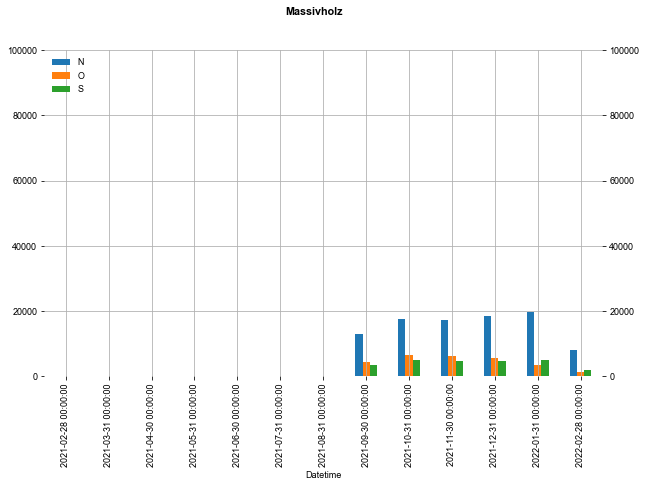

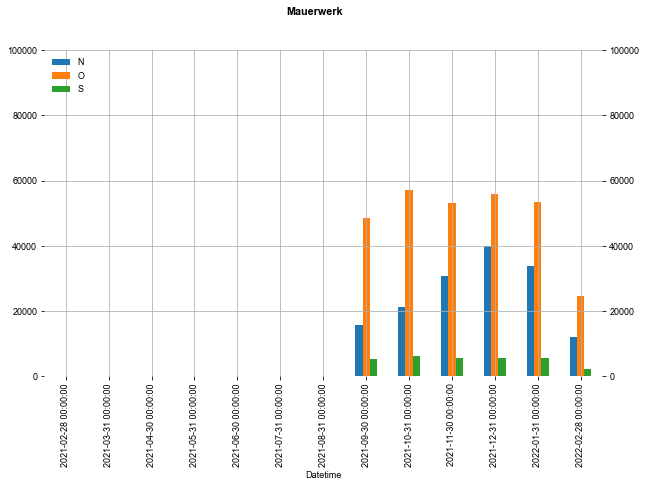

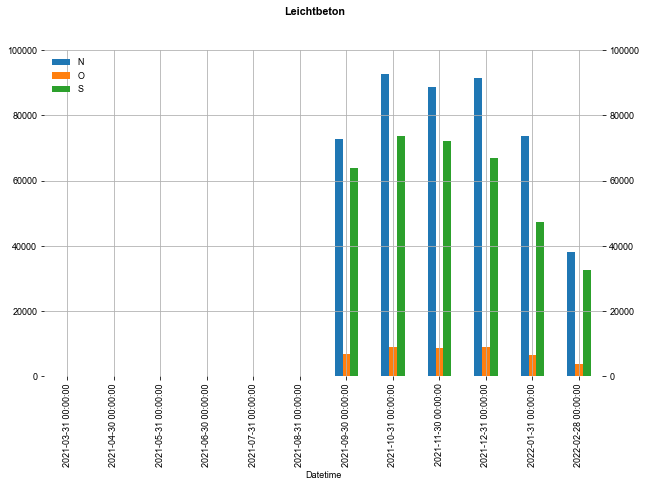

In [13]:
for color, bui in zip(['summer', 'autumn', 'winter'], eb.buid):
    fig, ax = plt.subplots()
    fig.suptitle(f'{eb.buid[bui]}')
    dataset = IND[bui].filter(like='(W)').abs().groupby(axis=1,level=0).sum().resample('min').last().resample('H').mean().resample('M').sum()
    dataset.plot.bar(ax=ax, label = [f'{bui}_{col}' for col in dataset.columns])
    ax.set_ylim(0,100000)
    ax.legend()